# House Prices: Advanced Regression Techniques

In [29]:
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
from matplotlib import pyplot as plt
import seaborn as sns

train = pd.read_csv('data/train.csv')
train = train.set_index('Id')
test = pd.read_csv('data/test.csv')

# Data Visualization: 
### What does the data look like?

In [26]:
train.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Text(0, 0.5, 'Count')

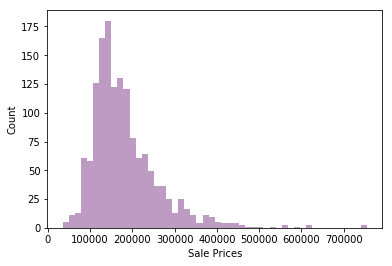

In [27]:
plt.hist(train.SalePrice, bins = 50, color = "#BD9BC2")
plt.xlabel('Sale Prices')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

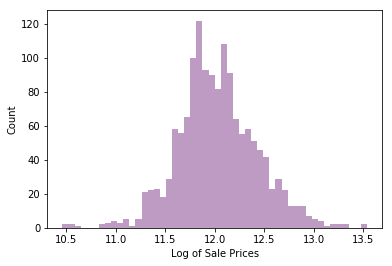

In [28]:
plt.hist(np.log(train.SalePrice), bins = 50, color = "#BD9BC2")
plt.xlabel('Log of Sale Prices')
plt.ylabel('Count')

In [30]:
# right skew to the target variable, but taking the log corrects corrects much of the issue

### Explore the relationship between sale price and other variables:

The top 5 positively & negatively correlated features:

In [31]:
numeric_features = train.select_dtypes(include=[np.number])
corr = numeric_features.corr()
print (corr['SalePrice'].sort_values(ascending=False)[:5], '\n')
print (corr['SalePrice'].sort_values(ascending=True)[:5])

SalePrice      1.000000
OverallQual    0.790982
GrLivArea      0.708624
GarageCars     0.640409
GarageArea     0.623431
Name: SalePrice, dtype: float64 

KitchenAbvGr    -0.135907
EnclosedPorch   -0.128578
MSSubClass      -0.084284
OverallCond     -0.077856
YrSold          -0.028923
Name: SalePrice, dtype: float64


Inspecting the relationships further:

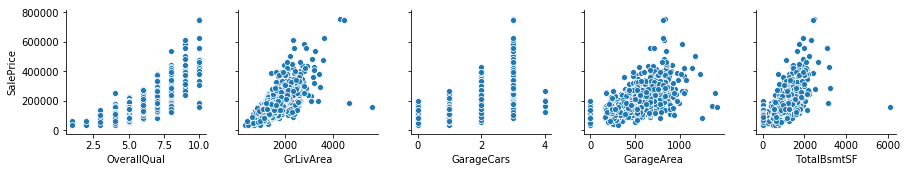

In [12]:
# top positively correlated variables
sns.pairplot(numeric_features[['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF']], 
            y_vars=['SalePrice'],
            x_vars=['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF'])

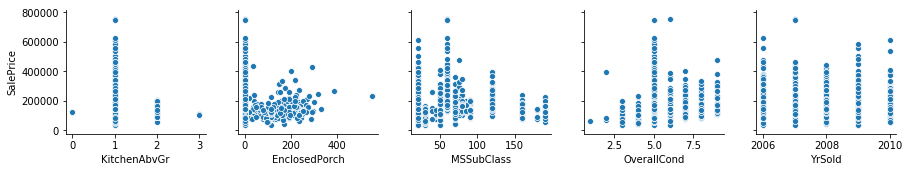

In [14]:
# top negatively correlated variables
sns.pairplot(numeric_features[['SalePrice', 'KitchenAbvGr', 'EnclosedPorch', 'MSSubClass', 'OverallCond', 'YrSold']],
            y_vars= ['SalePrice'], 
            x_vars = ['KitchenAbvGr', 'EnclosedPorch', 'MSSubClass', 'OverallCond', 'YrSold'])

In [32]:
categoricals = train.select_dtypes(exclude=[np.number])
categoricals.describe()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,...,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,...,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,...,870,605,1311,1326,1340,3,157,49,1267,1198


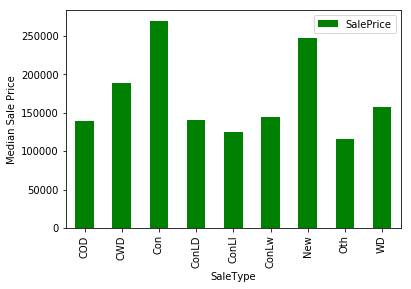

In [33]:
pivot = train.pivot_table(index='SaleType', values='SalePrice', aggfunc=np.median)
pivot.plot(kind='bar', color='green')
plt.xlabel('SaleType')
plt.ylabel('Median Sale Price')
#plt.xticks(rotation=0)
plt.show()

# Processing Data
Handle missingness and dummify categorical variables

### Missingness

In [125]:
missingCols = train.isnull().any(axis=0)
nulls = pd.DataFrame(train[train.columns[missingCols]].isnull().sum().sort_values(ascending=False))
nulls.columns = ['Null Count']
nulls.index.name = 'Feature'
nulls

,Null Count
Feature,


Continuous Variables:
Can impute mean or 0. Using mean for now, and 0 for the variable where 0 makes sense

In [35]:
numeric_features.columns[numeric_features.isnull().any(axis=0)]

Index(['LotFrontage', 'MasVnrArea', 'GarageYrBlt'], dtype='object')

In [36]:
train['LotFrontage'] = train['LotFrontage'].fillna(train['LotFrontage'].mean()) # unclear why NA 
train['GarageYrBlt'] = train['GarageYrBlt'].fillna(train['GarageYrBlt'].mean()) # better than other options
train['MasVnrArea'] = train['MasVnrArea'].fillna(0) # NA is from no masonry veneer area

Categorical Variables:
Data description confirms that NAs here means the feature doesn't exist at the house. Since these are categorical, making the lack of feature a category is natural. One row seems to be missing completely at random from the 'Electrical' column, so I am dropping that row.

In [37]:
train['PoolQC'] = train['PoolQC'].fillna('No Pool')
train['MiscFeature'] = train['MiscFeature'].fillna('None')
train['Alley'] = train['Alley'].fillna('No alley access')
train['Fence'] = train['Fence'].fillna('No Fence')
train['FireplaceQu'] = train['FireplaceQu'].fillna('No Fireplace')
train['GarageCond'] = train['GarageCond'].fillna('No Garage')
train['GarageQual'] = train['GarageQual'].fillna('No Garage')
train['GarageFinish'] = train['GarageFinish'].fillna('No Garage')
train['GarageType'] = train['GarageType'].fillna('No Garage')
train['BsmtFinType2'] = train['BsmtFinType2'].fillna('No Basement')
train['BsmtExposure'] = train['BsmtExposure'].fillna('No Basement')
train['BsmtFinType1'] = train['BsmtFinType1'].fillna('No Basement')
train['BsmtCond'] = train['BsmtCond'].fillna('No Basement')
train['BsmtQual'] = train['BsmtQual'].fillna('No Basement')
train['MasVnrType'] = train['MasVnrType'].fillna('None')

In [38]:
#drop missing electrical row
missingRows = train.isnull().any(axis=1)
train = train[-missingRows]

### Dummify Categorical Variables

In [50]:
# Features for LR use only:
dummified_features = train.iloc[:, 0:79].copy()
# Binary Categorical Variables can be changed to 0 or 1:
dummified_features['Street'] = dummified_features['Street'].apply(lambda x: 0 if x == 'Pave' else 1)
dummified_features['Utilities'] = dummified_features['Utilities'].apply(lambda x: 0 if x == 'AllPub' else 1)
dummified_features['CentralAir'] = dummified_features['CentralAir'].apply(lambda x: 0 if x == 'N' else 1)

# MSSubClass refers to categories, but is currently an integer type. Changing to string type, since the distance 
# between categories doesn't mean anything.
dummified_features['MSSubClass'] = dummified_features['MSSubClass'].astype(str)

In [61]:
categoricals = dummified_features.select_dtypes(exclude=[np.number])
categoricals.columns

Index(['MSSubClass', 'MSZoning', 'Alley', 'LotShape', 'LandContour',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'Electrical', 'KitchenQual', 'Functional',
       'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType',
       'SaleCondition'],
      dtype='object')

In [62]:
print(dummified_features.shape)
for variable in categoricals.columns:
    dummy = pd.get_dummies(dummified_features[variable], prefix=variable)
    dummy.drop('_'.join([variable, dummified_features[variable][1]]), axis=1, inplace=True) # 
    dummified_features = dummified_features.drop(variable, axis=1)  # drop the original feature
    dummified_features = pd.concat([dummified_features, dummy], axis=1) # concat original df and dummy horizontally
print(dummified_features.shape)

(1459, 79)
(1459, 272)


In [71]:
print(dummified_features.columns)

Index(['LotFrontage', 'LotArea', 'Street', 'Utilities', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       ...
       'SaleType_ConLD', 'SaleType_ConLI', 'SaleType_ConLw', 'SaleType_New',
       'SaleType_Oth', 'SaleCondition_Abnorml', 'SaleCondition_AdjLand',
       'SaleCondition_Alloca', 'SaleCondition_Family',
       'SaleCondition_Partial'],
      dtype='object', length=272)


# Process Test Data:

### Missingness

In [148]:
missingCols = test.isnull().any(axis=0)
nulls = pd.DataFrame(test[test.columns[missingCols]].isnull().sum().sort_values(ascending=False))
nulls.columns = ['Null Count']
nulls.index.name = 'Feature'
nulls

,Null Count
Feature,


In [144]:
numeric_test = test.select_dtypes(include=[np.number])
numeric_test.columns[numeric_test.isnull().any(axis=0)]

Index(['LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt',
       'GarageCars', 'GarageArea'],
      dtype='object')

In [145]:
test['LotFrontage'] = test['LotFrontage'].fillna(test['LotFrontage'].mean())
test['MasVnrArea'] = test['MasVnrArea'].fillna(0)
test['BsmtFinSF1'] = test['BsmtFinSF1'].fillna(test['BsmtFinSF1'].mean())
test['BsmtFinSF2'] = test['BsmtFinSF2'].fillna(test['BsmtFinSF2'].mean())
test['BsmtUnfSF'] = test['BsmtUnfSF'].fillna(test['BsmtUnfSF'].mean())
test['TotalBsmtSF'] = test['TotalBsmtSF'].fillna(test['TotalBsmtSF'].mean())
test['BsmtFullBath'] = test['BsmtFullBath'].fillna(test['BsmtFullBath'].mean())
test['BsmtHalfBath'] = test['BsmtHalfBath'].fillna(test['BsmtHalfBath'].mean())
test['GarageYrBlt'] = test['GarageYrBlt'].fillna(test['GarageYrBlt'].mean())
test['GarageCars'] = test['GarageCars'].fillna(test['GarageCars'].mean())
test['GarageArea'] = test['GarageArea'].fillna(test['GarageArea'].mean())

In [147]:
test['PoolQC'] = test['PoolQC'].fillna('No Pool')
test['MiscFeature'] = test['MiscFeature'].fillna('None')
test['Alley'] = test['Alley'].fillna('No alley access')
test['Fence'] = test['Fence'].fillna('No Fence')
test['FireplaceQu'] = test['FireplaceQu'].fillna('No Fireplace')
test['GarageFinish'] = test['GarageFinish'].fillna('No Garage')
test['GarageType'] = test['GarageType'].fillna('No Garage')
test['BsmtExposure'] = test['BsmtExposure'].fillna('No Basement')
test['BsmtFinType2'] = test['BsmtFinType2'].fillna('No Basement')
test['BsmtFinType1'] = test['BsmtFinType1'].fillna('No Basement')
test['MasVnrType'] = test['MasVnrType'].fillna('None')
test['Utilities'] = test['Utilities'].fillna(test['Utilities'].mode()[0])
test['Functional'] = test['Functional'].fillna(test['Functional'].mode()[0])
test['Exterior2nd'] = test['Exterior2nd'].fillna(test['Exterior2nd'].mode()[0])
test['Exterior1st'] = test['Exterior1st'].fillna(test['Exterior1st'].mode()[0])

test['GarageCond'] = test['GarageCond'].fillna('No Garage')
test['GarageQual'] = test['GarageQual'].fillna('No Garage')
test['BsmtCond'] = test['BsmtCond'].fillna('No Basement')
test['BsmtQual'] = test['BsmtQual'].fillna('No Basement')
test['MSZoning'] = test['MSZoning'].fillna(test['MSZoning'].mode()[0])
test['KitchenQual'] = test['KitchenQual'].fillna(test['KitchenQual'].mode()[0])
test['SaleType'] = test['SaleType'].fillna(test['SaleType'].mode()[0])

### Dummify Categorical Variables

In [153]:
dummified_test_features = test.iloc[:, 0:79].copy()

dummified_test_features['Street'] = dummified_test_features['Street'].apply(lambda x: 0 if x == 'Pave' else 1)
dummified_test_features['Utilities'] = dummified_test_features['Utilities'].apply(lambda x: 0 if x == 'AllPub' else 1)
dummified_test_features['CentralAir'] = dummified_test_features['CentralAir'].apply(lambda x: 0 if x == 'N' else 1)

# MSSubClass refers to categories, but is currently an integer type. Changing to string type, since the distance 
# between categories doesn't mean anything.
dummified_test_features['MSSubClass'] = dummified_test_features['MSSubClass'].astype(str)

In [154]:
test_categoricals = dummified_test_features.select_dtypes(exclude=[np.number])
test_categoricals.columns

Index(['MSSubClass', 'MSZoning', 'Alley', 'LotShape', 'LandContour',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'Electrical', 'KitchenQual', 'Functional',
       'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType'],
      dtype='object')

In [155]:
print(dummified_test_features.shape)
for variable in test_categoricals:
    dummy = pd.get_dummies(dummified_test_features[variable], prefix=variable)
    dummy.drop('_'.join([variable, dummified_test_features[variable][1]]), axis=1, inplace=True) # 
    dummified_test_features = dummified_test_features.drop(variable, axis=1)  # drop the original feature
    dummified_test_features = pd.concat([dummified_test_features, dummy], axis=1) # concat original df and dummy horizontally
print(dummified_test_features.shape)

(1459, 79)
(1459, 252)


### Match Features with Training Data (if necessary)

In [157]:
# 252 columns instead of 272. Need to make these match:
missing_cols = set(dummified_features.columns) - set(dummified_test_features.columns)
for c in missing_cols:
    dummified_test_features[c] = 0
dummified_test_features = dummified_test_features[dummified_features.columns]
print(dummified_test_features.shape)
print(dummified_features.shape)

(1459, 272)
(1459, 272)


# Linear Regression Models

## Mutiple Linear Regression

In [158]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

y = np.log(train.SalePrice)
X = dummified_features

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=213, test_size=.20)
mlr = linear_model.LinearRegression()
saturated_model = mlr.fit(X_train, y_train)

In [160]:
print ("Error for the training data : ", 1-saturated_model.score(X_train, y_train))
print ("Error for the test data : ", 1-saturated_model.score(X_test, y_test))

Error for the training data :  0.04905012850511381
Error for the test data :  0.17243492375945635


In [163]:
predictions = saturated_model.predict(X_test)
print ('RMSE :', np.sqrt(mean_squared_error(y_test, predictions)))

RMSE : 0.17604826885809527


Substantial overfitting in the saturated model

In [164]:
import statsmodels.api as sm
X_Constant = sm.add_constant(X_train)
model = sm.OLS(y_train, X_Constant)
results = model.fit()
print(results.summary()) 

D:\Anaconda\lib\site-packages\statsmodels\compat\pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)
D:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                     68.57
Date:                Mon, 20 Apr 2020   Prob (F-statistic):               0.00
Time:                        19:06:19   Log-Likelihood:                 1193.0
No. Observations:                1167   AIC:                            -1870.
Df Residuals:                     909   BIC:                            -564.0
Df Model:                         257                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

### Check assumptions of MLR:

Linearity:

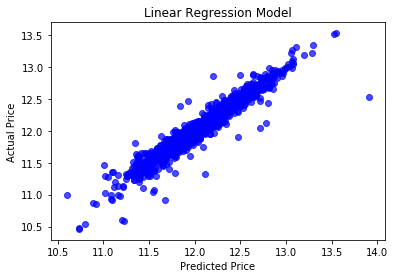

In [165]:
plt.scatter(saturated_model.predict(X), y, alpha=.7,
            color='b') #alpha helps to show overlapping data
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Linear Regression Model')
plt.show()

Normally distributed errors:

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   1.,   3.,
          2.,   0.,   3.,   0.,   5.,   7.,  39., 110., 327., 543., 293.,
         82.,  28.,   7.,   1.,   1.,   2.,   2.,   1.]),
 array([-1.38789813, -1.31977282, -1.2516475 , -1.18352219, -1.11539688,
        -1.04727157, -0.97914626, -0.91102095, -0.84289564, -0.77477033,
        -0.70664501, -0.6385197 , -0.57039439, -0.50226908, -0.43414377,
        -0.36601846, -0.29789315, -0.22976784, -0.16164252, -0.09351721,
        -0.0253919 ,  0.04273341,  0.11085872,  0.17898403,  0.24710934,
         0.31523465,  0.38335997,  0.45148528,  0.51961059,  0.5877359 ,
         0.65586121]),
 <a list of 30 Patch objects>)

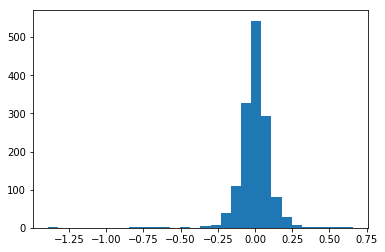

In [166]:
residuals = y - saturated_model.predict(X)
plt.hist(residuals, bins = 30)

Constant variance and independent Errors:

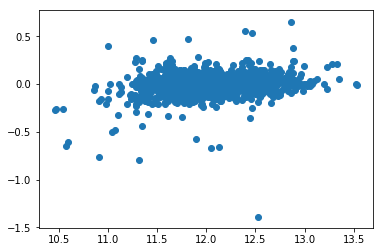

In [168]:
plt.scatter(y, residuals)

Multicollinearity:

Using all variables requires using many related variables, such as the numerous variables relating to the basement or the garage. These variables add different but related information. Lasso Regression will be used to address multicollinearity issues, decrease variance, and increase accuracy. It will have the additional benefit of feature selection.

## Ridge Linear Regression

In [180]:
target = train.SalePrice

In [220]:
from sklearn.linear_model import Lasso, Ridge

ridge = Ridge()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78, test_size=.20)

ridge.set_params(alpha = 0,normalize = True)
ridge.fit(X_train, y_train)
ridge.score(X_train, y_train)

0.9475199775989905

In [221]:
coefs = []
intercepts = []
R2_train  = []
R2_test  = []
alphaRange = np.linspace(1e-3,15,20)
for alpha in alphaRange:
        ridge.set_params(alpha=alpha, normalize=True)  
        ridge.fit(X_train, y_train)
        intercepts.append(ridge.intercept_)
        coefs.append(ridge.coef_)
        R2_train.append(ridge.score(X_train, y_train))
        R2_test.append(ridge.score(X_test, y_test))

Text(0.5, 1.0, 'Change of Ridge Slopes Varying Alpha')

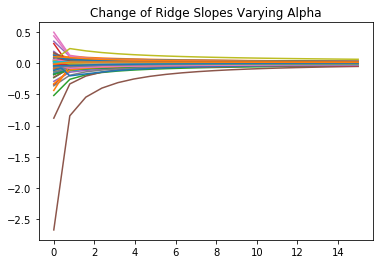

In [222]:
coefs = pd.DataFrame(np.array(coefs), columns=X.columns)

for name in coefs.columns:
    plt.plot(alphaRange, coefs[name], label=name)  
plt.title('Change of Ridge Slopes Varying Alpha')

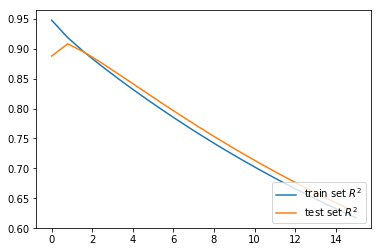

In [223]:
plt.plot(alphaRange, R2_train, label=r'train set $R^2$')
plt.plot(alphaRange, R2_test, label=r'test set $R^2$')
plt.legend(loc=4)

In [224]:
ridge.set_params(alpha=1.75, normalize=True)
best_alpha = ridge.fit(X_train, y_train)
print(best_alpha.score(X_train, y_train))
print(best_alpha.score(X_test, y_test))

0.8901832970307628
0.8912104678927534


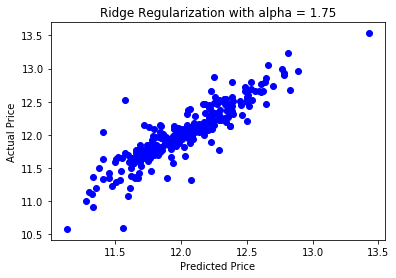

In [259]:
predictions = best_alpha.predict(X_test)
plt.scatter(predictions, y_test, alpha=1, color='b')
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Ridge Regularization with alpha = {}'.format(1.75))
plt.show()

In [226]:
print ('RMSE :', np.sqrt(mean_squared_error(y_test, predictions)))

RMSE : 0.13083817657989202


## Lasso Linear Regression

In [261]:
lasso = Lasso()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=213, test_size=.20)

lasso.set_params(alpha = 0,normalize = False)
lasso.fit(X_train, y_train)
lasso.score(X_train, y_train)

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  """
D:\Anaconda\lib\site-packages\sklearn\linear_model\coordinate_descent.py:478: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
D:\Anaconda\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.9508772347083614

In [270]:
coefs = []
intercepts = []
R2_train  = []
R2_test  = []
alphaRange = np.linspace(1e-3,15,20)
for alpha in alphaRange:
        lasso.set_params(alpha=alpha, normalize=False)  
        lasso.fit(X_train, y_train)
        intercepts.append(lasso.intercept_)
        coefs.append(lasso.coef_)
        R2_train.append(lasso.score(X_train, y_train))
        R2_test.append(lasso.score(X_test, y_test))

Text(0.5, 1.0, 'Change of Lasso Slopes Varying Alpha')

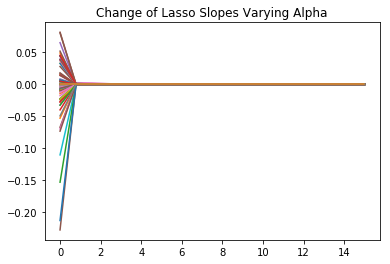

In [271]:
coefs = pd.DataFrame(np.array(coefs), columns=X.columns)

for name in coefs.columns:
    plt.plot(alphaRange, coefs[name], label=name)  
plt.title('Change of Lasso Slopes Varying Alpha')

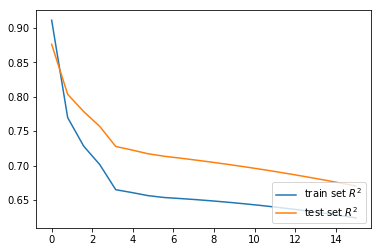

In [272]:
plt.plot(alphaRange, R2_train, label=r'train set $R^2$')
plt.plot(alphaRange, R2_test, label=r'test set $R^2$')
plt.legend(loc=4)

In [273]:
lasso.set_params(alpha=0.3, normalize=False)
best_alpha = lasso.fit(X_train, y_train)
print(best_alpha.score(X_train, y_train))
print(best_alpha.score(X_test, y_test))

0.785751878057122
0.7992214012411354


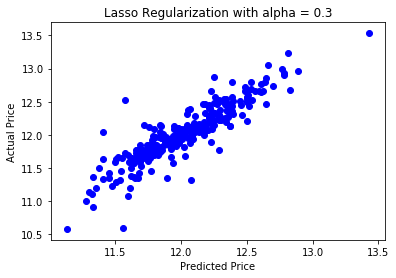

In [274]:
predictions = best_alpha.predict(X_test)
plt.scatter(predictions, y_test, alpha=1, color='b')
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Lasso Regularization with alpha = {}'.format(0.3))
plt.show()

In [275]:
print ('RMSE :', np.sqrt(mean_squared_error(y_test, predictions)))

RMSE : 0.18996686411870162


# Reduce Features Based on Models?

Re-run Models with reduced features